In [23]:
# tweaked trading strategy
# using daily price movements for 254 trading days (~ 1 calendar year)
#
import random
import numpy as np
import math

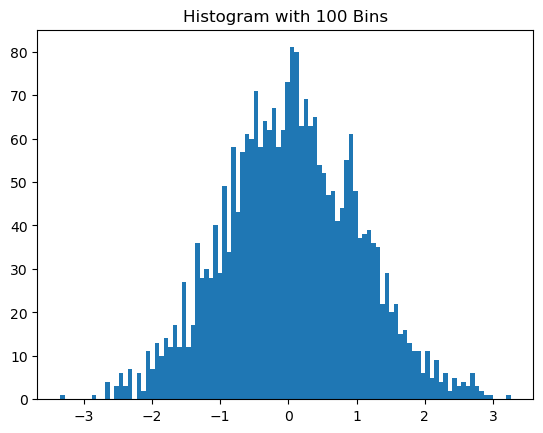

In [43]:
Totalpaths = 10
Nstep = 254 # Number of trading days (1 year = 254 trading days)
nran = Nstep * Totalpaths
# Initialize the r_draw array with zeros
r_draw = np.zeros(nran, dtype='float')
#
np.random.seed(125)
#
# Populate the r_draw array with normally distributed random values
for x in range(nran):
    r_draw[x] = np.random.normal(loc=0, scale=1)
import matplotlib.pyplot as plt
# Plotting the histogram for r_draw
_ = plt.hist(r_draw, bins=100)  # arguments are passed to np.histogram
plt.title("Histogram with 100 Bins")
plt.show()

In [35]:
# Define a series of price data
# Store in an array (NDAYS X NYEARS)
# Prices sampled at end of trading day
S0 = 100
T = 1
Sigma = 0.2
drift = 0.05
DeltaT = T / Nstep
print('DeltaT', DeltaT)
stockp = np.zeros(nran, dtype="float").reshape(Nstep, Totalpaths)
# Generate stock prices using the same method as the original script
npath = 0
S = S0
for x in range(0, nran):
    Snew = S * math.exp(((drift * DeltaT) + (Sigma * (DeltaT ** 0.5) * r_draw[x])))
    step = x % 254
    if step == 253:
        if npath < Totalpaths:
            stockp[step, npath] = Snew
            npath += 1
        S = S0
    else:
        S = Snew
        stockp[step, npath] = Snew
print('Final value of x:', x)
print('Last simulated price:', stockp[253, 0])

DeltaT 0.003937007874015748
Final value of x: 2539
Last simulated price: 125.6311931309908


In [41]:
# Trading Environment
# Define Short-term and Long-term moving averages
ltavg = np.zeros(Nstep, dtype='float')
stavg = np.zeros(Nstep, dtype='float')
S = S0
pnl = 0
long = 0
short = 0
mavg = 0
signal = np.zeros(254, dtype='int')
last = 0
short_window = 15 #variables that determine the range over which the averages are calculated
long_window = 30  #
# Calculate the averages
x = 0
for y in range(0, Nstep):
    if y == 0:
        ltavg[y] = S0
        stavg[y] = S0
    if y < long_window:
        ltavg[y] = ltavg[y - 1] + stockp[y, x]
    else:
        ltavg[y] = ltavg[y - 1] + stockp[y, x] - stockp[y - long_window, x]
    if y < short_window:
        stavg[y] = stavg[y - 1] + stockp[y, x]
    else:
        stavg[y] = stavg[y - 1] + stockp[y, x] - stockp[y - short_window, x]
# Divide by the number of periods to get the moving averages
for y in range(0, Nstep):
    stavg[y] = stavg[y] / short_window if y >= short_window else stavg[y] / (y + 1)
    ltavg[y] = ltavg[y] / long_window if y >= long_window else ltavg[y] / (y + 1)
pos = 0
trade = np.zeros(254, dtype='int')
last = 0
# Generate trading signals based on modified moving average strategy
buffer_zone = 0.5  # A buffer value to avoid too many signals
for y in range(long_window, Nstep):
    if stavg[y] > ltavg[y] + buffer_zone:
        if last == 0:
            trade[y] = 1  # Buy signal
            last = 1
    if stavg[y] < ltavg[y] - buffer_zone:
        if last == 1:
            trade[y] = -1  # Sell signal
            last = 0
    if y == 253:
        if last == 1:
            trade[y] = -1  # Ensure to close any open positions
            last = 0
# Calculate P&L
PandL = np.zeros(254, dtype='float')
BHRet = 0
Num_Buys = 0
Num_Sells = 0

for y in range(long_window, Nstep):
    if trade[y] == 1:  # Buy signal
        if BHRet == 0:
            BHRet = stockp[y, x]
        PandL[y] = PandL[y - 1] + stockp[y, x]
        Num_Buys += 1
    elif trade[y] == -1:  # Sell signal
        PandL[y] = PandL[y - 1] + stockp[y, x]
        Num_Sells += 1
    else:  # No trade
        PandL[y] = PandL[y - 1]
    if y == 253:
        BHRet = BHRet + stockp[y, x]
# Output final results
print('Buy-Hold Return:', BHRet)
print('Moving Average Strategy Return:', PandL[253])
print('Number of Buys:', Num_Buys)
print('Number of Sells:', Num_Sells)

Buy-Hold Return: 221.38060481718017
Moving Average Strategy Return: 630.6575816191278
Number of Buys: 3
Number of Sells: 3


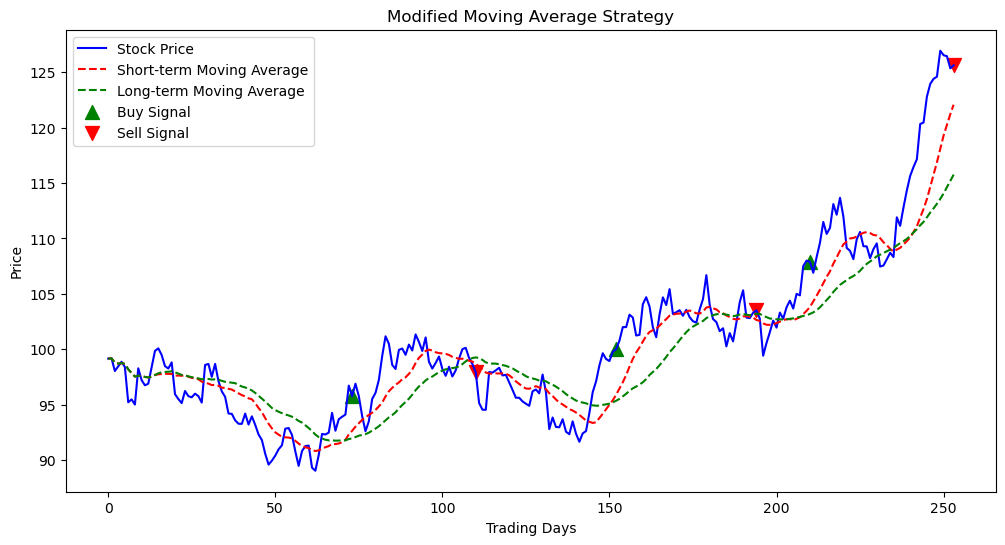

In [39]:
# Visualize the moving averages and trade signals
plt.figure(figsize=(12, 6))
plt.plot(stockp[:, 0], label='Stock Price', color='blue')
plt.plot(stavg, label='Short-term Moving Average', color='red', linestyle='--')
plt.plot(ltavg, label='Long-term Moving Average', color='green', linestyle='--')
# Mark the Buy and Sell signals
buy_signals = [i for i in range(len(trade)) if trade[i] == 1]
sell_signals = [i for i in range(len(trade)) if trade[i] == -1]
plt.scatter(buy_signals, stockp[buy_signals, 0], marker='^', color='g', label='Buy Signal', s=100)
plt.scatter(sell_signals, stockp[sell_signals, 0], marker='v', color='r', label='Sell Signal', s=100)
plt.title('Modified Moving Average Strategy')
plt.xlabel('Trading Days')
plt.ylabel('Price')
plt.legend()
plt.show()